In [5]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pystan 

INFO:matplotlib.font_manager:Could not open font file /Library/Fonts/NISC18030.ttf
INFO:matplotlib.font_manager:Could not open font file /System/Library/Fonts/Apple Color Emoji.ttf


# Implement models in Stan

## Call center data set — exponential likelihood with gamma prior

Size of data set: 5891
First 3 values in data set: [5.36 2.48 8.08]
Sum of data set: 1442.145437310004


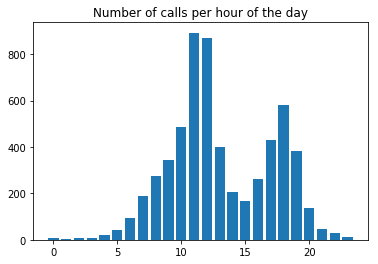

In [6]:
# Load the data set containing durations between calls arriving at the call center.
# All values are in minutes.
waiting_times_day = np.loadtxt('call-center.csv')
print('Size of data set:', len(waiting_times_day))
print('First 3 values in data set:', waiting_times_day[:3])
print('Sum of data set:', sum(waiting_times_day))

# Split the data into 24 separate series, one for each hour of the day
current_time = 0
waiting_times_per_hour = [[] for _ in range(24)]  # Make 24 empty lists, one per hour
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

# Plot the number of calls per hour
plt.bar(range(24), [len(w) for w in waiting_times_per_hour])
plt.title('Number of calls per hour of the day')
plt.show()

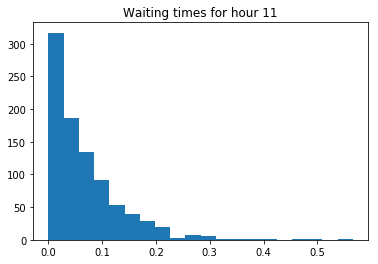

In [7]:
# Plot histogram of waiting times for hour
hour_index = 11
waiting_times_hour = waiting_times_per_hour[hour_index]
plt.hist(waiting_times_hour, bins=20)
plt.title('Waiting times for hour %i' % hour_index)
plt.show()

In [54]:
stan_code = """
data {
   real alpha;
   real beta;
   int N;
   real wait_time[N];
}

parameters {
    real lambda;
}
model {
   lambda ~ gamma(alpha, beta);
   wait_time ~ exponential(lambda);
}
"""
stan_data = {'wait_time':waiting_times_hour,
        'N': len(waiting_times_hour),
        'alpha': 1,
        'beta': 0.25}


We see that the Stan model returns a 95% posterior interval of [13.89, 15.84], which matches with the analytical approximation as shown in the solution to the pre-class work.

In [55]:
stan_model = pystan.StanModel(model_code=stan_code)
stan_results = stan_model.sampling(data=stan_data)
posterior_samples = stan_results.extract()
print(stan_results.stansummary(pars=['lambda'], probs=[0.025, 0.5, 0.975]))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb66b16382f9a254164e06941104bda2 NOW.
/anaconda3/envs/stan_env/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2c/xyn8g_s90939jkf_j_4c8ywc0000gn/T/tmpan0qj62_/stanfit4anon_model_bb66b16382f9a254164e06941104bda2_484806446787112203.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Inference for Stan model: anon_model_bb66b16382f9a254164e06941104bda2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
lambda  14.86    0.01   0.52  13.87  14.86  15.89   1437    1.0

Samples were drawn using NUTS at Wed Oct 17 22:54:39 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


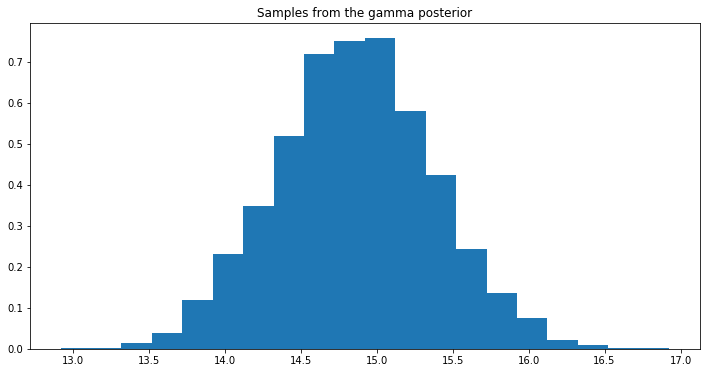

In [56]:
# Plot the histogram of the posterior samples
plt.figure(figsize=(12, 6))
plt.hist(posterior_samples["lambda"], bins=20, density=True)
plt.title('Samples from the gamma posterior')
plt.show()

## Normal likelihood with normal-inverse-gamma prior

In [50]:
given_data = np.array([3.54551763569501, 4.23799861761927, 4.72138425951628, -0.692265320368236, 
                 3.04473513808788, 3.10721270732507, 3.42982225852764, 3.12153903971176, 
                 3.60532628639808, 2.46561737557325, 1.64059465916131, 2.4621623937158, 
                 2.76744495617481, 2.11580054750407, 5.14077208608354, 4.90288499104252, 
                 1.43357579078348, 4.78997817363558, 1.93633438207439, 2.43698838097178, 
                 3.95389148701877, 2.4242295507716, 2.90256268679023, 2.90931728045901, 
                 0.658072819386888, 3.05946763895983, 3.42615331539605, 2.68842833004417, 
                 2.35850130765166, 2.20014998540933, 4.73846511350084, 4.19839721414451, 
                 2.11805510171691, -0.572742936038015, 0.389413982010623, 3.87846130744249, 
                 1.34057656890858, 0.7235748351719, 5.11042369840174, 4.00747556696571, 
                 3.18080956726965, 3.24677964069676, 5.1154659863626, 1.80276616697155, 
                 0.305877679021404, -0.449168307882718, 4.63705561194774, 1.37783714058301, 
                 4.9608149859515, 6.7764195802069, 1.75515522922399, 7.04457337435215, 
                 0.625185284955128, 2.25130734369064, 2.19770178119255, 2.16858257249432, 
                 6.25367644481438, 0.116081323476489, 2.06315857864341, 1.82409781471718, 
                 5.15226741230987, 2.03408231293173, -1.12450854337596, 5.03511270642234, 
                 2.03841989653263, 5.80911741751597, 2.31718128783245, 4.97575010580997, 
                 3.34262752222776, -0.786983904253601, 0.777362359850013, 0.975825009321195, 
                 3.76354577515958, 7.27215002907876, 1.35404089480189, 3.76567940257157, 
                 3.48573993343334, 1.85976988586156, 1.93567061960716, 5.31071812003942, 
                 2.96832987672751, 3.32378908637275, 2.61631960054551, 5.80897964052825, 
                 4.95215217171488, 1.32036772796131, 3.79932542233371, 3.08108492766309, 
                 2.6734110081666, -0.14251851138521, 2.48744375588965, 3.98463042123415, 
                 6.32781680028, 4.0029172024315, 4.23210369459457, 1.71412938967325, 
                 5.16492114963802, 2.53409673107906, 4.77346963973334, 3.34088878725551, 
                 4.77681472750664, 3.81135755590976, 1.14054269983137, 1.42057452397702, 
                 0.132142311125433, 7.12577254064672, 4.85422012781764, 4.15745720676399, 
                 4.48763147363348, 1.56060322283629, 2.64821761542887, 1.26655351354548, 
                 4.48497722937931, 4.3286302403783, 4.26157679512625, 4.0597558651364, 
                 5.14051109132496, 2.5660348362221, 1.10764013818617, 0.386889523012303, 
                 3.54150473246237, 3.57480214382351, 1.95150869584847, 2.70688970563118, 
                 2.47971849820016, 6.50838037000679, 4.01511556826974, 1.11562740835344, 
                 5.02637639472439, 4.38184491686864, 5.60423144047386, 2.40067408379298, 
                 5.7849941378344, 2.37225791084559, 6.86031465910273, 4.09214858239736, 
                 6.85994063692621, 3.62202415158781, -1.11220646958158, 3.73920971696866, 
                 3.24533871512216, 1.28724203643002, 0.291152541773164, 0.368630935755111, 
                 6.71607270510525, 5.42278455200833, 5.35188416119281, 2.305874586163, 
                 -1.85878097203032, 2.69877382351447, 4.84121860550417, 4.40973060799391, 
                 5.04399320650774, 2.68632252661298, 6.06531610659912, 3.11881325011993, 
                 3.45532087005125, 3.08442259840346, 4.43564424136733, 2.84252623135804, 
                 1.50536798885106, 1.48868622407603, 2.07322837615663, 2.5476910210998, 
                 5.66941808257884, 2.16731067416426, 2.49843958833905, 3.94586413879977, 
                 0.316433764679541, -0.608937441815983, 2.5943436558557, 1.05516869528337, 
                 2.1447601332725, 6.65846634141906, 2.1771555267834, 5.23953812029442, 
                 3.53629759842647, 6.03263538017003, 3.85739159396599, 5.95093453004638, 
                 1.12856987160476, 3.5559912886093, 2.21974864244489, 3.38471394882135, 
                 -1.90805399279409, 3.5113699258973, 4.49319955412346, 5.10507952638867, 
                 1.08277895384184, 4.58403638422759, 1.37304994426824, 4.17566975753523, 
                 3.36454182510378, 0.177136582644021, 2.91337423388405, 3.22796455457526, 
                 2.80124198378441, 1.95189718582788, 3.37659263896246, -1.6463045238231])
print(len(given_data), "data")

200 data


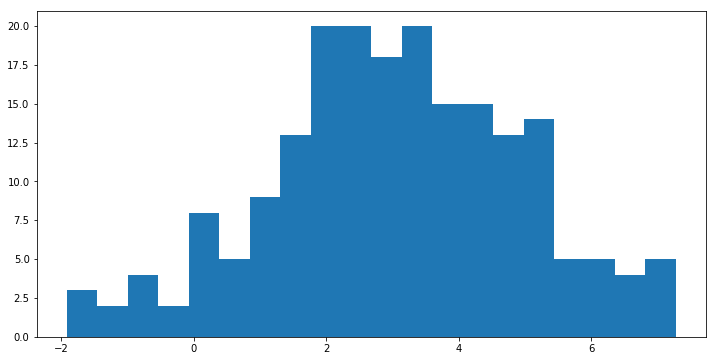

Data sample mean: 3.065080189542003
Data sample variance: 3.6152141787699223


In [32]:
# Plot a histogram of the data. Do the data look normally distributed?
plt.figure(figsize=(12, 6))
plt.hist(given_data, bins=20)
plt.show()

# Calculate the sample mean and variance of the data
print('Data sample mean:', np.mean(given_data))
print('Data sample variance:', np.var(given_data))

Note that the `normal` construct in Stan uses the standard deviation, so we have to square root our variance.

In [58]:
stan_code = """
data {
    real mu_0;
    real nu_0;
    real alpha_0;
    real beta_0;
    int N;
    real y[N];
}

parameters {
    real mean_model;
    real variance_model;
}
model {
   variance_model ~ inv_gamma(alpha_0, beta_0);
   mean_model ~ normal(mu_0, sqrt(variance_model / nu_0));
   y ~ normal(mean_model, sqrt(variance_model));
}
"""
stan_data = {'y': given_data,
        'N': len(given_data),
        "mu_0" : 0,        # The prior mean is centered around 0.
        "nu_0" : 0.054,    # The smaller nu_0 is, the more uncertain we are about the prior mean.
        "alpha_0" : 1.12,  # alpha and beta govern the marginal prior over the variance.
        "beta_0" : 0.4}


The 95% posterior confidence intervals for the mean of the data is [2.79, 3.33]. The 95% posterior confidence intervals for the variance of the data is [2.98, 4.43]. This matches the analytical solution for the posterior distribution.  

In [59]:
stan_model = pystan.StanModel(model_code=stan_code)
stan_results = stan_model.sampling(data=stan_data)
posterior_samples = stan_results.extract()
print(stan_results.stansummary(pars=['mean_model', 'variance_model'], probs=[0.025, 0.5, 0.975]))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5b2655e44078d19c524acd77273d6635 NOW.
/anaconda3/envs/stan_env/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2c/xyn8g_s90939jkf_j_4c8ywc0000gn/T/tmpdh62y3mz/stanfit4anon_model_5b2655e44078d19c524acd77273d6635_1292436403844835252.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Inference for Stan model: anon_model_5b2655e44078d19c524acd77273d6635.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
mean_model       3.06  2.8e-3   0.14   2.79   3.06   3.33   2428    1.0
variance_model   3.63  6.8e-3   0.37   2.98   3.61   4.43   2926    1.0

Samples were drawn using NUTS at Wed Oct 17 23:02:20 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


We can take 10 samples from the `posterior_samples` variable.

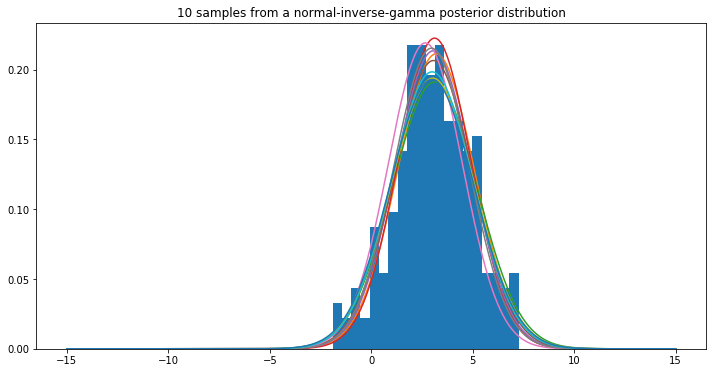

In [60]:
# Generate 10 samples from the posterior samples returned
num_samples = 10
samples = np.random.randint(len(posterior_samples["mean_model"]), size=10)
means = posterior_samples["mean_model"][samples]
variances = posterior_samples["variance_model"][samples]

# Plot the normal distributions corresponding to the samples
plt.figure(figsize=(12, 6))
plt.hist(given_data, bins=20, density=True)
plot_x = np.linspace(-15, 15, 500)
for i in range(num_samples):
    plot_y = stats.norm.pdf(plot_x, loc=means[i], scale=np.sqrt(variances[i]))
    plt.plot(plot_x, plot_y)
plt.title('%i samples from a normal-inverse-gamma posterior distribution' % num_samples)
plt.show()


## Log-normal HRTEM data

In [16]:
# Load data: read the particle sizes (in nanometers) from a CSV file.
hrtem = np.loadtxt('hrtem.csv')
print('%i data, min: %f, max: %f' % (len(data), min(data), max(data)))

500 data, min: 1.051827, max: 28.942578


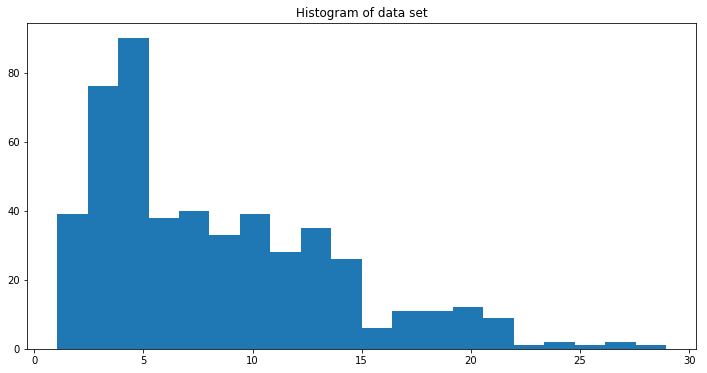

In [17]:
# Data are very skew and all values are positive, so probably non-normal.
plt.figure(figsize=(12,6))
plt.hist(hrtem, bins=20)
plt.title('Histogram of data set')
plt.show()

### Transforming the data

Use the log function to transform the data and plot a histogram of the transformed data.

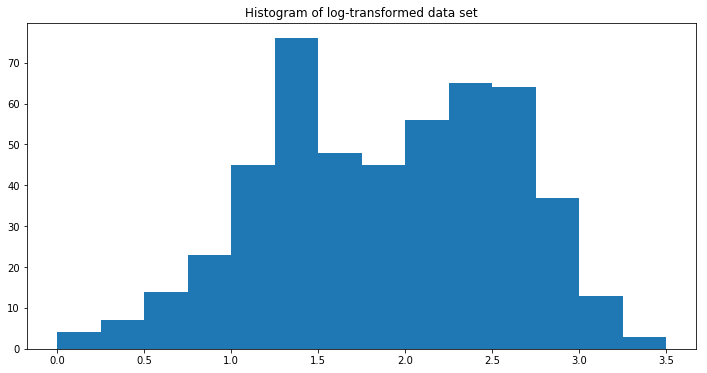

In [18]:
log_hrtem = np.log(hrtem)

# Data are very skew and all values are positive, so probably non-normal.
plt.figure(figsize=(12,6))
plt.hist(log_hrtem, bins=np.linspace(0, 3.5, 15))
plt.title('Histogram of log-transformed data set')
plt.show()

In [61]:
stan_code = """
data {
    real mu_0;
    real nu_0;
    real alpha_0;
    real beta_0;
    int N;
    real log_hrtem[N];
}

parameters {
    real mean_model;
    real variance_model;
}
model {
   variance_model ~ inv_gamma(alpha_0, beta_0);
   mean_model ~ normal(mu_0, sqrt(variance_model / nu_0));
   log_hrtem ~ normal(mean_model, sqrt(variance_model));
}
"""
stan_data = {'log_hrtem':log_hrtem,
        'N': len(log_hrtem),
        'mu_0' : 2.3,
        'nu_0' : 0.1,
        'alpha_0' : 2,
        'beta_0' : 5}


The 95% posterior confidence intervals for the mean of the log-transformed data is [1.83, 1.95]. The 95% posterior confidence intervals for the variance of the log-transformed data is [0.44, 0.56]. This matches the analytical solution for the posterior distribution.  

In [62]:
stan_model = pystan.StanModel(model_code=stan_code)
stan_results = stan_model.sampling(data=stan_data)
posterior_samples = stan_results.extract()
print(stan_results.stansummary(pars=['mean_model', 'variance_model'], probs=[0.025, 0.5, 0.975]))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2eafc67584d35ac794b5addeeb24fadb NOW.
/anaconda3/envs/stan_env/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2c/xyn8g_s90939jkf_j_4c8ywc0000gn/T/tmp_asa_yet/stanfit4anon_model_2eafc67584d35ac794b5addeeb24fadb_4351316112833597418.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Inference for Stan model: anon_model_2eafc67584d35ac794b5addeeb24fadb.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
mean_model       1.89  5.1e-4   0.03   1.83   1.89   1.95   3832    1.0
variance_model    0.5  5.3e-4   0.03   0.44   0.49   0.56   3509    1.0

Samples were drawn using NUTS at Wed Oct 17 23:06:05 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


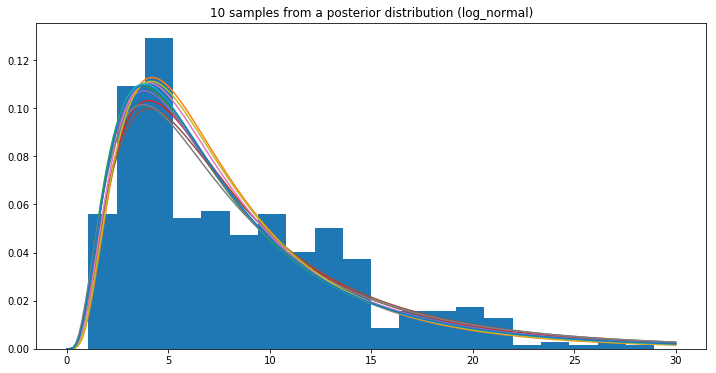

In [63]:
# Generate 10 samples from the posterior samples returned
num_samples = 10
samples = np.random.randint(len(posterior_samples["mean_model"]), size=10)
means = posterior_samples["mean_model"][samples]
variances = posterior_samples["variance_model"][samples]

plt.figure(figsize=(12,6))
plt.hist(hrtem, bins=20, density=True)
plot_x = np.linspace(0, 30, 200)
for i in range(num_samples):
    plot_y = stats.lognorm.pdf(plot_x, np.sqrt(variances[i]), scale=np.exp(means[i]))
    plt.plot(plot_x, plot_y)
plt.title('%i samples from a posterior distribution (log_normal)' % num_samples)
plt.show()

## Mixture of Gaussians for HRTEM Data set

We use the log-transformed data-set which is bimodal. Here we use the `ordered` data type to improve model identifiability. To learn more about this, watch the video given in the assignment.

In [181]:
stan_code = """
data {
    real mu_0;
    real alpha_0;
    real beta_0;
    real mix_alpha;
    real mix_beta;
    int N;
    real log_hrtem[N];
}

parameters {
    ordered[2] mu;
    real<lower=0> sigma[2];
    real<lower=0,upper=1> p;
}
model {
    for (i in 1:2) sigma[i] ~ gamma(alpha_0, beta_0);
    for (i in 1:2) mu[i] ~ normal(1, 2);    
    p ~ beta(mix_alpha, mix_beta);
    for (i in 1:N)
        target += log_mix(p, normal_lpdf(log_hrtem[i] | mu[1], sigma[1]), normal_lpdf(log_hrtem[i] | mu[2], sigma[2]));
}
"""
stan_data = {'log_hrtem':log_hrtem,
        'N': len(log_hrtem),
        'mu_0' : 0,
        'nu_0' : 0.1,
        'alpha_0' : 2,
        'beta_0' : 2,
        'mix_alpha': 3,
        'mix_beta': 3}


In [183]:
stan_model = pystan.StanModel(model_code=stan_code)
stan_results = stan_model.sampling(data=stan_data)
posterior_samples = stan_results.extract()
print(stan_results.stansummary(pars=['mu', 'sigma', 'p'], probs=[0.025, 0.5, 0.975]))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6bfe916f3eab7e5a70bd5f1e38688dec NOW.
/anaconda3/envs/stan_env/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2c/xyn8g_s90939jkf_j_4c8ywc0000gn/T/tmpc9xoib7i/stanfit4anon_model_6bfe916f3eab7e5a70bd5f1e38688dec_1999918799807863055.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Inference for Stan model: anon_model_6bfe916f3eab7e5a70bd5f1e38688dec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
mu[1]      1.43  2.4e-3   0.08    1.3   1.43    1.6   1019   1.01
mu[2]      2.51  1.3e-3   0.05   2.41   2.51   2.61   1722    1.0
sigma[1]    0.5  1.4e-3   0.05   0.42   0.49   0.59   1150    1.0
sigma[2]   0.35  7.8e-4   0.03   0.29   0.35   0.41   1631    1.0
p          0.57  1.8e-3   0.06   0.47   0.57    0.7   1105    1.0

Samples were drawn using NUTS at Thu Oct 18 16:30:49 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


We plot the marginal posterior distributions for each parameter. 

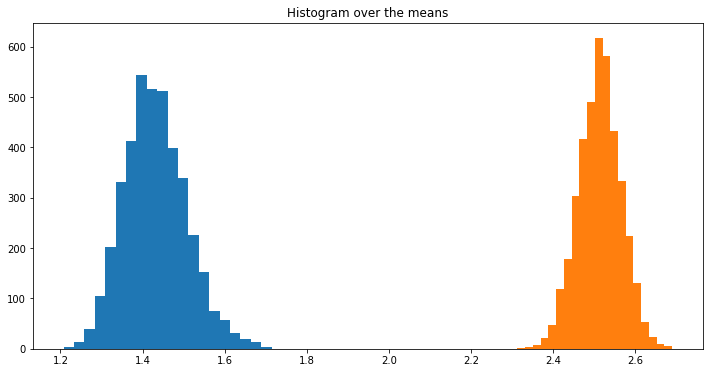

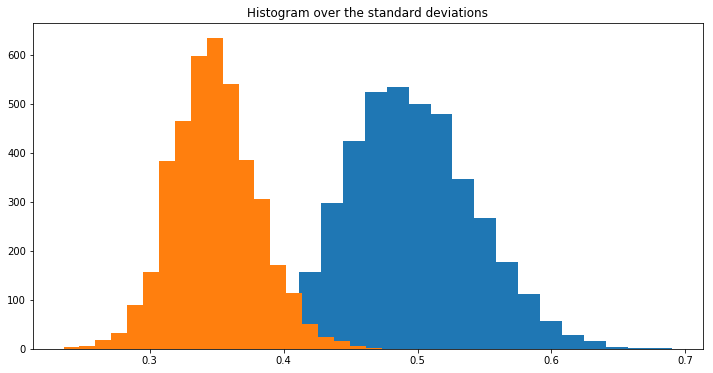

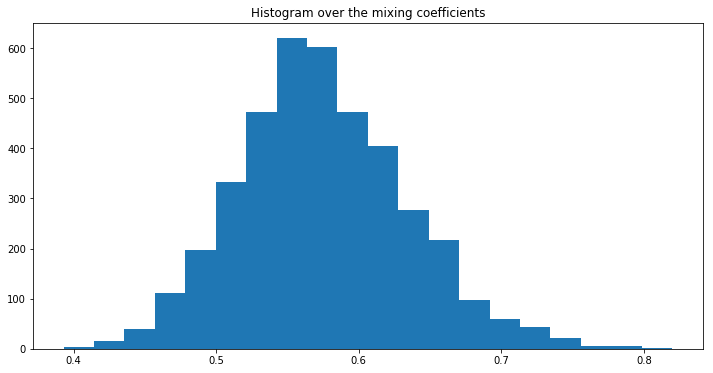

In [198]:
plt.figure(figsize=(12,6))
plt.title("Histogram over the means")
plt.hist(posterior_samples["mu"][:, 0], bins=20)
plt.hist(posterior_samples["mu"][:, 1], bins=20)
plt.show()
plt.figure(figsize=(12,6))
plt.title("Histogram over the standard deviations")
plt.hist(posterior_samples["sigma"][:, 0], bins=20)
plt.hist(posterior_samples["sigma"][:, 1], bins=20)
plt.show()
plt.figure(figsize=(12,6))
plt.title("Histogram over the mixing coefficients")
plt.hist(posterior_samples["p"], bins=20)
plt.show()

Using joint samples from the posterior, we can plot the likelihood function for the data and show that it fits the data generation process. 

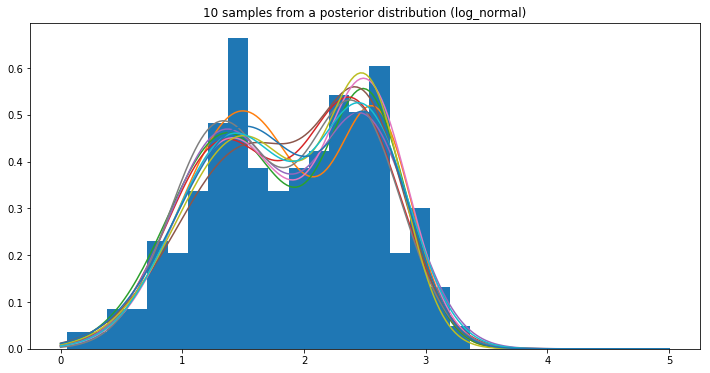

In [193]:
# Generate 10 samples from the posterior samples returned
num_samples = 10
samples = np.random.randint(len(posterior_samples["mu"]), size=10)
means = posterior_samples["mu"][samples]
sigma = posterior_samples["sigma"][samples]
p = posterior_samples["p"][samples]

plt.figure(figsize=(12,6))
plt.hist(log_hrtem, bins=20, density=True)
plot_x = np.linspace(0, 5, 200)
for i in range(num_samples):
    plot_y = ((p[i] * stats.norm.pdf(plot_x, loc=means[i, 0], scale=sigma[i, 0])) 
              + (1 - p[i]) * stats.norm.pdf(plot_x, loc=means[i, 1], scale=(sigma[i, 1])))
    plt.plot(plot_x, plot_y)
plt.title('%i samples from a posterior distribution (log_normal)' % num_samples)
plt.show()

# Question 1 (Optional Exercise)

* We use a conjugate Dirichlet-Multinomial model to describe voter preferences. If we assume a uniform prior before the debate, the posterior distribution over voter preferences follows a $\vec{x} ~ Dir(x|\vec{\alpha}_0)$ where $\vec{\alpha}_0 = (295,308,39)$. If we also assume a uniform prior after the debate, the posterior distribution over voter preferences follows a $\vec{x} ~ Dir(x|\vec{\alpha}_1)$ where $\vec{\alpha}_1 = (289,333,20)$

* To sample from the distribution of $\alpha_0$, we sample from $x_1$ and $x_2$ (representing Bush's and Dukakis' support) from the Dirichlet before debate posterior and compute the difference between $x_1$ and $x_2$. To sample from the distribution of $\alpha_1$, we sample from $x_1$ and $x_2$ (representing Bush's and Dukakis' support) from the Dirichlet after debate posterior and compute the difference between $x_1$ and $x_2$. We then simply substract the two to plot the histogram.

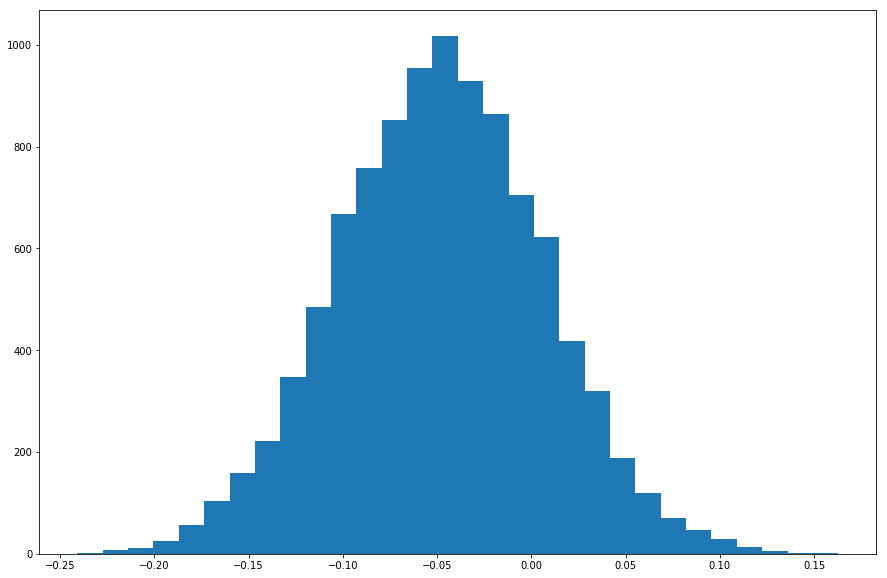

In [26]:
voters = np.random.dirichlet([295,308,39], size = 10000)
x1 = voters[:, 0]
x2 = voters[:, 1]
a0 = x1 - x2
voters = np.random.dirichlet([289,333,20], size = 10000)
x1 = voters[:, 0]
x2 = voters[:, 1]
a1 = x1 - x2
plt.figure(figsize=(15,10))
plt.hist(a1 - a0, 30)
plt.show()

* Voter preference shifted towards Dukakis after the debate if $\alpha_1 - \alpha_0 < 0$ (i.e. the difference in voter preference for Bush after the debate is smaller than before).

In [27]:
voter_pref = np.sum((a1 - a0) < 0) / len(a1 - a0)
print ("The probability that voter preference shifted towards Dukakis after the debate is", voter_pref)

The probability that voter preference shifted towards Dukakis after the debate is 0.8101


# Question 2 (Optional Exercise)

Derivation of conjugate distribution update equations. Derive the posterior distribution over
the parameter $p$ of the binomial likelihood function if it has a conjugate beta prior
distribution over $p$.

Suppose the prior distribution of $p$ is $$\mathbb{P}(p|\alpha_0, \beta_0) = \frac{p^{\alpha_0-1}(1-p)^{\beta_0 - 1}}{B(\alpha_0, \beta_0)}$$ where $\alpha_0, \beta_0$ are the prior hyperparameters of the beta distribution. 

The binomial likelihood function is defined $$ \mathbb{P} (x|p, n) =  \left(\begin{array}{c}n\\ x\end{array}\right) p^x (1-p)^{n-x}$$

We thus have the posterior distribution over the parameter $p$ by applying Bayes' Theorem.
$$\mathbb{P} (p|x, \alpha_0, \beta_0,n) = \frac{\mathbb{P}(x, p| n, \alpha_0, \beta_0)}{\mathbb{P}(x|n, \alpha_0, \beta_0)} = \frac{\mathbb{P}(x|p, n) \mathbb{P}(p|\alpha_0, \beta_0)}{\mathbb{P}(x|n, \alpha_0, \beta_0)}= \frac{\mathbb{P}(x|p, n) \mathbb{P}(p|\alpha_0, \beta_0)}{\int _0^1\mathbb{P}(x|p,n)\mathbb{P}(p|\alpha_0, \beta_0) dp}$$

The second equality is true due to the conditional independence of $x$ on $\alpha_0, \beta_0$ given $p$ and the independence of $p$ on $n$. More on conditional independence in the graphical models unit.

Substituting the prior and the likelihood, we have
$$\mathbb{P} (p|x, \alpha_0, \beta_0,n) = \frac{\frac{1}{B(\alpha_0, \beta_0)}\left(\begin{array}{c}n\\ x\end{array}\right)p^x (1-p)^{n-x}p^{\alpha_0-1}(1-p)^{\beta_0 - 1}}{\int _0^1 \frac{1}{B(\alpha_0, \beta_0)}\left(\begin{array}{c}n\\ x\end{array}\right)p^x (1-p)^{n-x}p^{\alpha_0-1}(1-p)^{\beta_0 - 1} dp}$$

Pulling out the factor $\frac{1}{B(\alpha_0, \beta_0)}\left(\begin{array}{c}n\\ x\end{array}\right)$ in the integral since it is with respect to $p$ and cancelling them, we have 
$$\mathbb{P} (p|x, \alpha_0, \beta_0,n) = \frac{p^{x+\alpha_0-1} (1-p)^{n-x+\beta_0 - 1}}{\int _0^1 p^{x+\alpha_0-1} (1-p)^{n-x+\beta_0 - 1} dp}$$

We recognize the [beta integral](https://en.wikipedia.org/wiki/Beta_function) in the denominator as the normalizing constant for a $Beta(\alpha_0+x, \beta_0+n-x)$ distribution.

# Question 3 (Optional Exercise)

* The Normal-Inverse-Gamma distribution has pdf
  \begin{align*}
    p(x,\sigma ^2|\mu,\lambda,\alpha,\beta) = \frac{\sqrt{\lambda} }{\sigma \sqrt{2\pi }}\frac{\beta ^\alpha }{\Gamma (\alpha) }\left( \frac{1}{\sigma ^2}\right )^{\alpha +1}e^{-\frac{2\beta +\lambda (x-\mu )^2}{2\sigma ^2}}
  \end{align*}
* Maximizing the pdf is equivalent to maximizing the log pdf, since log is a monotonic function.
$$\log p(x,\sigma ^2|\mu,\lambda,\alpha,\beta) = \log\frac{\sqrt{\lambda} } { \sqrt{2\pi }} + \log\frac{\beta ^\alpha }{\Gamma (\alpha) } -\log\sigma+ \log\left( \frac{1}{\sigma ^2}\right )^{\alpha +1} -\frac{2\beta +\lambda (x-\mu )^2}{2\sigma ^2}\\
=-\log\sigma-2 (\alpha +1)\log\sigma -\frac{2\beta +\lambda (x-\mu )^2}{2\sigma ^2} + const.\\
=-(2\alpha + 3)\log\sigma-\frac{2\beta +\lambda (x-\mu )^2}{2\sigma ^2} + const.\\
=-\left(\alpha + \frac{3}{2} \right)\log\sigma^2-\frac{2\beta +\lambda (x-\mu )^2}{2\sigma ^2} + const.$$

Here we have collected into $const.$ the terms that do not depend on $x$ and $\sigma ^2$ and thus do not matter for the optimization.

* The partial derivative of the log pdf with respect to $x$ is
\begin{align*} \frac{\partial}{\partial x}\log p(x,\sigma ^2|\mu,\lambda,\alpha,\beta) &= \frac{\partial}{\partial x}\left [  -\left(\alpha + \frac{3}{2} \right)\log\sigma^2-\frac{2\beta +\lambda (x-\mu )^2}{2\sigma ^2} + const.\right]\\
&=-\frac{\lambda (x-\mu )^2}{\sigma ^2}\end{align*}

* The partial derivative of the pdf with respect to $\sigma^2$ is
\begin{align*}
    \frac{\partial}{\partial \sigma ^2}\log p(x,\sigma ^2|\mu,\lambda,\alpha,\beta) &= \frac{\partial}{\partial \sigma ^2}\left [  -\left(\alpha + \frac{3}{2} \right)\log\sigma^2-\frac{2\beta +\lambda (x-\mu )^2}{2\sigma ^2} + const.\right]\\
&=-\left(\alpha +\frac{3}{2}\right)\left( \frac{1}{\sigma ^2}\right )+\frac{2\beta +\lambda (x-\mu )^2}{2\sigma ^4} \end{align*}

* To find the maximizers of the log pdf, we set the partial derivatives to zero and solve the nonlinear system of equations
  \begin{align*}
    \begin{cases}    -\frac{\lambda (x-\mu )}{\sigma ^2}&=0\\
\frac{2\beta +\lambda (x-\mu )^2}{2\sigma ^4}-\left(\alpha +\frac{3}{2}\right)\left( \frac{1}{\sigma ^2}\right )&=0 
\end{cases}
  \end{align*}
  The first equation implies that the numerator must be zero. Therefore, $x=\mu$. 
  Substituting this into the second equation, we obtain
  \begin{align*}
    \frac{\beta }{\sigma ^4}-\left(\alpha +\frac{3}{2}\right)\left( \frac{1}{\sigma ^2}\right )=\beta -\left(\alpha +\frac{3}{2}\right)\sigma ^2=0  
  \end{align*}
  A rigorous optimizer would apply the second derivative test to check if these points are truly the maximum, but we can argue that this point is truly the maximum because these are the critical points of a probability distribution that asymptotically approaches zero as $x$ and $\sigma^2$ approach infinity (and thus have no global minimum).
  Therefore the values of $x$ and $\sigma^2$ that maximize the pdf are:
  \begin{align*}
    \begin{cases}    x&=\mu\\
\sigma^2&=\frac{\beta}{\alpha+\frac{3}{2}}
\end{cases} 
  \end{align*}